In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Read the solved data

In [3]:
data = pd.read_csv("solved_data.csv")

Split the data

In [4]:
train_data, rest_of_data = train_test_split(data, train_size=2500, shuffle=True, random_state=42)
val_data, test_data = train_test_split(rest_of_data, test_size=500, shuffle=True, random_state=42)

X_train = train_data.drop(columns=["ChurnStatus", "CustomerID"])
y_train = train_data["ChurnStatus"]

X_val = val_data.drop(columns=["ChurnStatus", "CustomerID"])
y_val = val_data["ChurnStatus"]

X_test = test_data.drop(columns=["ChurnStatus", "CustomerID"])
y_test = test_data["ChurnStatus"]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(2500, 6) (2500,)
(500, 6) (500,)
(500, 6) (500,)


## Linear Decision Boundry

Create the model, train, test, and evaluate the metrics on each set.

In [5]:
# Define the model
model_1 = LogisticRegression(max_iter=500, solver='lbfgs')

# Train the model
model_1.fit(X_train, y_train)

# Find the metrics on each set
y_train_pred_1 = model_1.predict(X_train)
train_accuracy_1 = accuracy_score(y_train, y_train_pred_1)
train_precision_1 = precision_score(y_train, y_train_pred_1)
train_recall_1 = recall_score(y_train, y_train_pred_1)

y_val_pred_1 = model_1.predict(X_val)
val_accuracy_1 = accuracy_score(y_val, y_val_pred_1)
val_precision_1 = precision_score(y_val, y_val_pred_1)
val_recall_1 = recall_score(y_val, y_val_pred_1)

y_test_pred_1 = model_1.predict(X_test)
test_accuracy_1 = accuracy_score(y_test, y_test_pred_1)
test_precision_1 = precision_score(y_test, y_test_pred_1)
test_recall_1 = recall_score(y_test, y_test_pred_1)

linear_metrics_train = [train_accuracy_1, train_precision_1, train_recall_1]
linear_metrics_val = [val_accuracy_1, val_precision_1, val_recall_1]
linear_metrics_test = [test_accuracy_1, test_precision_1, test_recall_1]

metrics_table = pd.DataFrame({
    "Train": linear_metrics_train,
    "Validation": linear_metrics_val,
    "Test": linear_metrics_test
}, index=["Accuracy", "Precision", "Recall"])

print(metrics_table)

              Train  Validation      Test
Accuracy   0.976000    0.978000  0.980000
Precision  0.795699    0.750000  0.882353
Recall     0.643478    0.631579  0.652174


## Non-linear Decision Boundry

### Degree = 2

In [6]:
# Define the polynomail feature
poly_2 = PolynomialFeatures(degree=2, include_bias=False)

# Learn and apply polynomial features to the training set
X_train_2 = poly_2.fit_transform(X_train)

# Apply the learned one on the val and test sets
X_val_2 = poly_2.transform(X_val)
X_test_2 = poly_2.transform(X_test)

# Defile the model
model_2 = LogisticRegression(max_iter=500, solver='lbfgs')

# Train the model
model_2.fit(X_train_2, y_train)

# Evaluate the metrics on each set
y_train_pred_2 = model_2.predict(X_train_2)
train_accuracy_2 = accuracy_score(y_train, y_train_pred_2)
train_precision_2 = precision_score(y_train, y_train_pred_2)
train_recall_2 = recall_score(y_train, y_train_pred_2)

y_val_pred_2 = model_2.predict(X_val_2)
val_accuracy_2 = accuracy_score(y_val, y_val_pred_2)
val_precision_2 = precision_score(y_val, y_val_pred_2)
val_recall_2 = recall_score(y_val, y_val_pred_2)

y_test_pred_2 = model_2.predict(X_test_2)
test_accuracy_2 = accuracy_score(y_test, y_test_pred_2)
test_precision_2 = precision_score(y_test, y_test_pred_2)
test_recall_2 = recall_score(y_test, y_test_pred_2)

non_linear_2_metrics_train = [train_accuracy_2, train_precision_2, train_recall_2]
non_linear_2_metrics_val = [val_accuracy_2, val_precision_2, val_recall_2]
non_linear_2_metrics_test = [test_accuracy_2, test_precision_2, test_recall_2]

non_linear_2_table = pd.DataFrame({
    "Train": non_linear_2_metrics_train,
    "Validation": non_linear_2_metrics_val,
    "Test": non_linear_2_metrics_test
}, index=["Accuracy", "Precision", "Recall"])

print(non_linear_2_table)


              Train  Validation      Test
Accuracy   0.981600    0.978000  0.984000
Precision  0.841584    0.722222  0.857143
Recall     0.739130    0.684211  0.782609


### Degree = 5

In [7]:
# Define the polynomail feature
poly_5 = PolynomialFeatures(degree=5, include_bias=False)

# Learn and apply polynomial features to the training set
X_train_5 = poly_5.fit_transform(X_train)

# Apply the learned one on the val and test sets
X_val_5 = poly_5.transform(X_val)
X_test_5 = poly_5.transform(X_test)

# Define the model
model_5 = LogisticRegression(max_iter=500, solver='lbfgs')

# Train the model
model_5.fit(X_train_5, y_train)

# Evaluate the metrics on each set
y_train_pred_5 = model_5.predict(X_train_5)
train_accuracy_5 = accuracy_score(y_train, y_train_pred_5)
train_precision_5 = precision_score(y_train, y_train_pred_5)
train_recall_5 = recall_score(y_train, y_train_pred_5)

y_val_pred_5 = model_5.predict(X_val_5)
val_accuracy_5 = accuracy_score(y_val, y_val_pred_5)
val_precision_5 = precision_score(y_val, y_val_pred_5)
val_recall_5 = recall_score(y_val, y_val_pred_5)

y_test_pred_5 = model_5.predict(X_test_5)
test_accuracy_5 = accuracy_score(y_test, y_test_pred_5)
test_precision_5 = precision_score(y_test, y_test_pred_5)
test_recall_5 = recall_score(y_test, y_test_pred_5)

non_linear_5_metrics_train = [train_accuracy_5, train_precision_5, train_recall_5]
non_linear_5_metrics_val = [val_accuracy_5, val_precision_5, val_recall_5]
non_linear_5_metrics_test = [test_accuracy_5, test_precision_5, test_recall_5]

non_linear_5_table = pd.DataFrame({
    "Train": non_linear_5_metrics_train,
    "Validation": non_linear_5_metrics_val,
    "Test": non_linear_5_metrics_test
}, index=["Accuracy", "Precision", "Recall"])

print(non_linear_5_table)


              Train  Validation      Test
Accuracy   0.998400    0.990000  0.984000
Precision  0.991150    0.791667  0.826087
Recall     0.973913    1.000000  0.826087


### Degree = 9

In [17]:
# Define the polynomail feature
poly_9 = PolynomialFeatures(degree=9, include_bias=False)

# Learn and apply polynomial features to the training set
X_train_9 = poly_9.fit_transform(X_train)

# Apply the learned one on the val and test sets
X_val_9 = poly_9.transform(X_val)
X_test_9 = poly_9.transform(X_test)

# Define the model
model_9 = LogisticRegression(max_iter=500, solver='lbfgs')

# Train the model
model_9.fit(X_train_9, y_train)

# Evaluate the metrics on each set
y_train_pred_9 = model_9.predict(X_train_9)
train_accuracy_9 = accuracy_score(y_train, y_train_pred_9)
train_precision_9 = precision_score(y_train, y_train_pred_9)
train_recall_9 = recall_score(y_train, y_train_pred_9)

y_val_pred_9 = model_9.predict(X_val_9)
val_accuracy_9 = accuracy_score(y_val, y_val_pred_9)
val_precision_9 = precision_score(y_val, y_val_pred_9)
val_recall_9 = recall_score(y_val, y_val_pred_9)

y_test_pred_9 = model_9.predict(X_test_9)
test_accuracy_9 = accuracy_score(y_test, y_test_pred_9)
test_precision_9 = precision_score(y_test, y_test_pred_9)
test_recall_9 = recall_score(y_test, y_test_pred_9)

non_linear_9_metrics_train = [train_accuracy_9, train_precision_9, train_recall_9]
non_linear_9_metrics_val = [val_accuracy_9, val_precision_9, val_recall_9]
non_linear_9_metrics_test = [test_accuracy_9, test_precision_9, test_recall_9]

non_linear_9_table = pd.DataFrame({
    "Train": non_linear_9_metrics_train,
    "Validation": non_linear_9_metrics_val,
    "Test": non_linear_9_metrics_test
}, index=["Accuracy", "Precision", "Recall"])

print(non_linear_9_table)

           Train  Validation     Test
Accuracy     1.0    0.988000  0.98200
Precision    1.0    0.782609  0.85000
Recall       1.0    0.947368  0.73913


## Summary

In [11]:
def print_model_table(model_name, train_metrics, val_metrics, test_metrics):
    print(f"=== {model_name} ===")
    print(f"{'Dataset':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10}")
    print(f"{'Train':<12} {train_metrics[0]:<10.3f} {train_metrics[1]:<10.3f} {train_metrics[2]:<10.3f}")
    print(f"{'Validation':<12} {val_metrics[0]:<10.3f} {val_metrics[1]:<10.3f} {val_metrics[2]:<10.3f}")
    print(f"{'Test':<12} {test_metrics[0]:<10.3f} {test_metrics[1]:<10.3f} {test_metrics[2]:<10.3f}")
    print()

print_model_table("Linear Logistic Regression", linear_metrics_train, linear_metrics_val, linear_metrics_test)

print_model_table("Non-linear Logistic Regression (Degree 2)", non_linear_2_metrics_train, non_linear_2_metrics_val, non_linear_2_metrics_test)

print_model_table("Non-linear Logistic Regression (Degree 5)", non_linear_5_metrics_train, non_linear_5_metrics_val, non_linear_5_metrics_test)

print_model_table("Non-linear Logistic Regression (Degree 9)", non_linear_9_metrics_train, non_linear_9_metrics_val, non_linear_9_metrics_test)


=== Linear Logistic Regression ===
Dataset      Accuracy   Precision  Recall    
Train        0.976      0.796      0.643     
Validation   0.978      0.750      0.632     
Test         0.980      0.882      0.652     

=== Non-linear Logistic Regression (Degree 2) ===
Dataset      Accuracy   Precision  Recall    
Train        0.982      0.842      0.739     
Validation   0.978      0.722      0.684     
Test         0.984      0.857      0.783     

=== Non-linear Logistic Regression (Degree 5) ===
Dataset      Accuracy   Precision  Recall    
Train        0.998      0.991      0.974     
Validation   0.990      0.792      1.000     
Test         0.984      0.826      0.826     

=== Non-linear Logistic Regression (Degree 9) ===
Dataset      Accuracy   Precision  Recall    
Train        1.000      1.000      1.000     
Validation   0.988      0.783      0.947     
Test         0.982      0.850      0.739     



## Model Selection Based on Validation Set

To choose the best model among the four candidates, we focus on the **validation set** metrics.  

In our churn prediction system, a **False Negative (FN)** — predicting that a customer will stay when they actually churn — is more dangerous than a False Positive, because it means **we lose a customer**. Therefore, we prioritize **Recall** when evaluating models.  

From the validation results, it is clear that the **degree-5 polynomial logistic regression model** is the best, achieving **100% recall** on the validation set. This means it correctly identifies all customers who are likely to churn.


### Combining Precision and Recall: F1-score

To evaluate the balance between Precision and Recall, we compute the **F1-score** for each model:

In [26]:
f1_linear = f1_score(y_val, y_val_pred_1)
print("Linear Logistic Regression F1 Score:  ", f1_linear)

f1_deg2 = f1_score(y_val, y_val_pred_2)
print("Degree 2 Logistic Regression F1 Score:", f1_deg2)

f1_deg5 = f1_score(y_val, y_val_pred_5)
print("Degree 5 Logistic Regression F1 Score:", f1_deg5)

f1_deg9 = f1_score(y_val, y_val_pred_9)
print("Degree 9 Logistic Regression F1 Score:", f1_deg9)


Linear Logistic Regression F1 Score:   0.6857142857142857
Degree 2 Logistic Regression F1 Score: 0.7027027027027027
Degree 5 Logistic Regression F1 Score: 0.8837209302325582
Degree 9 Logistic Regression F1 Score: 0.8571428571428571


We can see that the **degree-5 model** achieves the **highest F1-score** → degree-5 remains the best choice based on the F1-score. 

**Conclusion:**  
- If our priority is **minimizing False Negatives (maximizing Recall)** → degree-5 is the best.  
- If we want to consider both **Precision and Recall** → degree-5 remains the best choice based on the F1-score.  

## ROC Curve


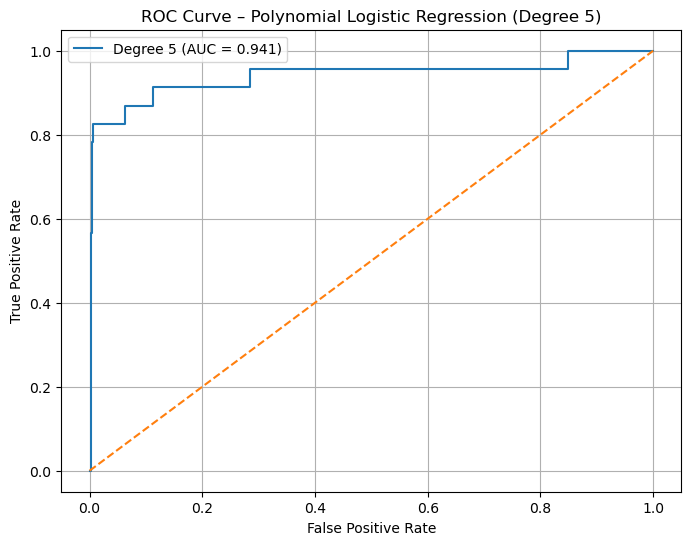

In [ ]:
y_test_proba_5 = model_5.predict_proba(X_test_5)[:, 1]

fpr_5, tpr_5, thresholds_5 = roc_curve(y_test, y_test_proba_5)
roc_auc_5 = auc(fpr_5, tpr_5)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_5, tpr_5, label=f"Degree 5 (AUC = {roc_auc_5:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.title("ROC Curve – Polynomial Logistic Regression (Degree 5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()